In [1]:
import time
import os
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from IPython import display

from dataset import Dataset, MultiscaleDataset
from gen_video import gen_batched_img, gen_video, gen_mip_video

In [2]:
train_set = MultiscaleDataset('../public/data/lego', 'blender',
        partition='train')
val_set = MultiscaleDataset('../public/data/lego', 'blender',
        partition='val')
H, W = train_set.H, train_set.W

Camera position mean & std:
[ -1.9723758  -11.407406     0.36299774] [10.950828   5.4356313 11.073948 ]
Camera position mean & std:
[ -0.97222143 -11.682014     0.6100528 ] [10.584989   5.2982874 11.329139 ]


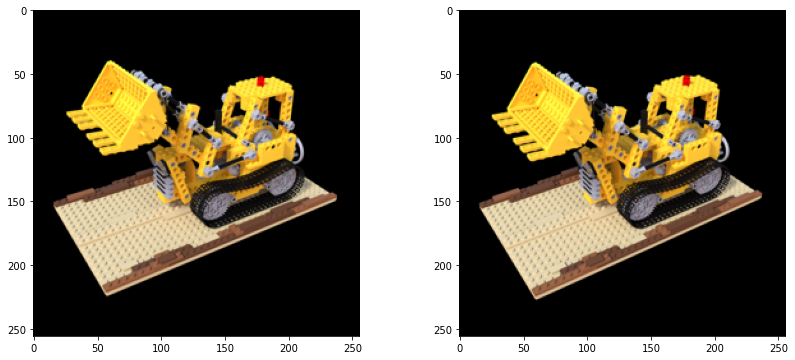

In [3]:
train_id = 68
val_id = 24

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.imshow(train_set.images[train_id].permute(1,2,0))
plt.subplot(122)
plt.imshow(val_set.images[val_id].permute(1,2,0))
plt.show()

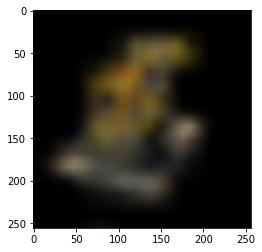

In [4]:
ray_ids = torch.arange(H*W, H*W*2)
idxy = train_set.idxy_from_ray_ids(ray_ids.cuda())
idsxy = torch.cat([idxy[:,:1], torch.ones_like(idxy[:,:1]) * 0.1, idxy[:,1:]], dim=-1)
rgb = train_set.sample(idsxy.reshape(1, H, W, 4))[0]
plt.imshow(rgb.clip(0,1).reshape(3, H, W).permute(1, 2, 0).cpu())

In [5]:
gen_mip_video(train_set, 'videos/mip.mp4')
display.clear_output()
display.display(display.HTML('<video src="videos/mip.mp4" controls=true autoplay=true loop=true />'))

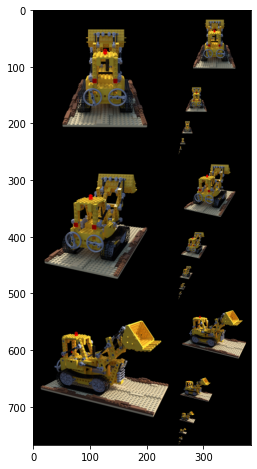

In [6]:
plt.figure(figsize=(14, 8))
plt.imshow(train_set.images_full[:, :256*3].permute(1, 2, 0).cpu())

In [7]:
# todo: use either 2, 3 for both
def ray_box_intersection(rays, bounds, zero_miss=True):
    """Find intersection of rays with a box
    
    Args:
        rays: Tensor with shape [None, 6]. Each row should be
            [x, y, z, dx, dy, dz]
        bounds: Tensor with shape [3, 2] or [None, 3, 2] representing
            min and max coords of the box on each axis
        zero_miss: Set coords to 0 for missed rays
    
    Returns shape [None, 2, 3] tensor with nearest and furthest
        intersection coords rescaled to [0, 1]
        and a shape [None,] hit mask
    """
    ro = rays[:, :3]
    rd = rays[:, 3:]
    if bounds.dim() == 2:
        bounds_expanded = bounds.unsqueeze(0).expand(rays.shape[0], 3, 2)
    else:
        bounds_expanded = bounds
    signs = (rd < 0).long().unsqueeze(-1)
    near_bounds = bounds_expanded.gather(-1, signs).squeeze(-1)
    t_near = ((near_bounds - ro) / rd).max(dim=-1)[0]
    far_bounds = bounds_expanded.gather(-1, 1 - signs).squeeze(-1)
    t_far = ((far_bounds - ro) / rd).min(dim=-1)[0]
    pts = torch.stack([
        ro + rd * t_near.unsqueeze(-1),
        ro + rd * t_far.unsqueeze(-1)
    ], dim=1)
    bounds_range = (bounds_expanded[:, :, 1] - bounds_expanded[:, :, 0]).unsqueeze(1).expand(pts.shape)
    pts_rescaled = (pts - bounds_expanded[:, :, 0].unsqueeze(1).expand(pts.shape)) / bounds_range
    hit_mask = t_near < t_far
    if zero_miss:
        pts_rescaled[~hit_mask] = 0
    return pts_rescaled, hit_mask

In [8]:
def raymarch(model, ro, rd, s, res):
    """Raymarch through a voxel volume
    
    Args:
        model: obj with voxel_fn(), that predicts [r, g, b, density] from 9d input (voxel xyz, 6d localized ray encoding) 
        ro: Normalized ray origins with shape [None, 3]. Origins should be in the range [0, 1]
        rd: Ray directions with shape [None, 3]
        s: pixel size (todo: cone angle)
        res: Resolution tensor with shape [3,]
    
    Returns a [None, 3] tensor containing accumulated RGB for each ray
    """
    # initialization
    ro = ro * res
    X = ro.clamp(torch.zeros(3, device='cuda'), res - 1).long()
    step = rd.sign().long()
    t_delta = (1 / rd).abs()
    t_max = (X + (step * 0.5 + 0.5) - ro).abs() * t_delta
    acc_density = torch.zeros_like(ro[:, :1])
    rgb = torch.zeros_like(ro)
    active = torch.arange(ro.shape[0], device='cuda').long()
    
    res = res[None, :]
    while active.shape[0] != 0:
        roa = ro[active]
        rda = rd[active]
        voxel_coords = X[active] + 0.5
        # get localized ray
        ro_to_vox = voxel_coords - roa
        t = (ro_to_vox * rda).sum(dim=-1, keepdim=True)
        local_ro = roa + rda * t
        local_ro = (local_ro - voxel_coords) * 2
        local_rays = torch.cat([voxel_coords * 2 / res - 1, local_ro, rda], dim=-1)
        local_rays = torch.cat([(roa + rda * t) * 2 / res - 1, rda], dim=-1)
        
        # x_near_corner = X[active] + (-step[active] * 0.5 + 0.5)
        # x2_near_corner = x_near_corner.clone()
        # x2_near_corner[torch.arange(x2_near_corner.shape[0]), step_axis] += step[active, step_axis]
        # ray_t1 = ((x_near_corner - roa).abs() * t_delta[active]).min(dim=-1, keepdim=True)[0]
        # ray_t2 = ((x2_near_corner - roa).abs() * t_delta[active]).min(dim=-1, keepdim=True)[0]
        
        # compute intersection lengths
        #x_near_corner = X[active] + (-step[active] * 0.5 + 0.5)
        #bds = torch.stack([X[active], X[active] + 1], axis=-1)
        bds = torch.tensor([[-1, 1] for _ in range(3)], device='cuda')
        #print(bds.shape)
        pts, hit = ray_box_intersection(torch.cat([local_ro, rda], axis=-1), bds)
        #print(((pts[:, 1] - pts[:, 0]) * rda).sum(dim=-1))
        #print(hit.shape, hit.int().sum())
        int_len = torch.linalg.vector_norm(pts[:, 1] - pts[:, 0], dim=-1, keepdim=True)
        #print(local_ro.min(), local_ro.max(), int_len.min(), int_len.max())
        
        # accumulate color and density
        vi = model.voxel_fn(torch.cat([local_rays, s[active]], dim=-1))
        density = vi[:, 3, None].relu() # no negative density
        #density = torch.tensor([2], device='cuda')
        # multiply by voxel intersection length
        density = density * int_len
        alpha = 1 - torch.exp(-density)
        transmittance = torch.exp(-acc_density[active])
        rgb[active] += vi[:, :3] * alpha * transmittance
        acc_density[active] += density
        
        # step X to next voxel
        step_axis = t_max[active].min(dim=-1)[1]
        X[active, step_axis] += step[active, step_axis]
        t_max[active, step_axis] += t_delta[active, step_axis]
        
        # deactivate if stepped outside bounds
        active_mask = (X[active] >= 0).all(dim=-1).logical_and((X[active] < res).all(dim=-1))
        active = active[active_mask]
    
    return rgb

In [9]:
def gaussian(x, sigma):
    return torch.exp(-x**2 / (2 * sigma**2))

def lerp(a, b, t):
    return a * (1 - t) + b * t

In [19]:
scene_bds = torch.tensor([
    [-2, 2], [-2.5, 1.5], [-2.5, 1.5]
], device='cuda').float() * 2.5
voxel_res = torch.ones(3, device='cuda') * 2

softplus = nn.Softplus()

class LipLinear(nn.Module):
    def __init__(self, in_features, out_features, c):
        super().__init__()
        k = 1 / in_features
        self.w = nn.Parameter(
            (torch.rand(in_features, out_features, requires_grad=True)
            * 2 - 1) * np.sqrt(k))
        self.b = nn.Parameter(
            (torch.rand(out_features, requires_grad=True)
            * 2 - 1) * np.sqrt(k))
        self.c = nn.Parameter(torch.tensor(
            [c], dtype=torch.float32, requires_grad=True))
    
    def forward(self, x):
        absrowsum = self.w.abs().sum(dim=1)
        scale = torch.minimum(torch.ones_like(self.c),
                              softplus(self.c) / absrowsum)
        return x @ (self.w * scale[:, None]) + self.b

class Model(nn.Module):
    def __init__(self, n_feats=256, n_layers=5):
        super().__init__()
        self.n_feats = n_feats
        
        c1 = np.sqrt(1 / 6) * n_feats
        c2 = np.sqrt(1 / n_feats) * n_feats
        c3 = np.sqrt(1 / n_feats) * 3
        layers = [LipLinear(7, n_feats, c1)] \
            + [LipLinear(n_feats, n_feats, c2) for _ in range(n_layers - 2)] \
            + [LipLinear(n_feats, 4, c3)]
        self.layers = nn.ModuleList(layers)
        
        self.scene_points = torch.zeros(1, 3, device='cuda')
        
    def voxel_fn(self, x):
        h = x.clone()
        x[:, :3] *= 5
        for i, layer in enumerate(self.layers[:-1]):
            h = layer(h)
            h = gaussian(h, lerp(0.2, 0.05, i / (len(self.layers) - 2)))
        y = self.layers[-1](h)
        return y
    
    def forward(self, rays):
        pts, hit_mask = ray_box_intersection(rays[..., :6], scene_bds)
        ptsfar = pts[:, 1]
        pts = pts[:, 0]
        rgb = torch.zeros_like(pts)
        rgb[hit_mask] = raymarch(model, pts[hit_mask], rays[hit_mask, 3:6],
                                 rays[hit_mask, 6:7], voxel_res)
        return rgb

model = Model()
model.cuda()

mse_loss_fn = nn.MSELoss()
alpha = 1e-7
def lip_loss_fn():
    C = torch.stack([softplus(l.c) for l in model.layers])
    lip_loss = alpha * C.prod()
    return lip_loss

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,
#    lambda epoch: max(0.8 ** epoch, 0.1))
lip_losses = []
train_mse_losses = []
val_mse_losses = []

2000/2000
2m47s - eta 0s


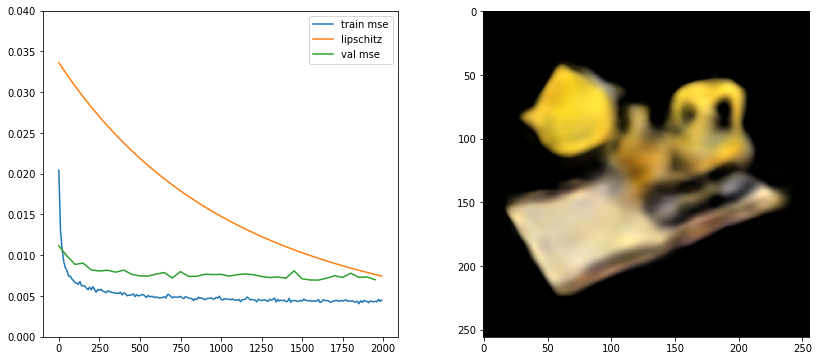

training mse loss: 0.004362039547413587
lipschitz loss: 0.007666255813091993
validation mse loss: 0.007240542536601424


In [20]:
train_st = time.time()
time_to_s = lambda t: (f'{int(t / 60)}m' if t >= 60 else '') + f'{int(t) % 60}s'

train_loss_freq = 10
val_loss_freq = 50
val_batch_size = int(1e4)

n_iter = int(2e3)
#n_iter = int(1e9)
batch_size = int(5e4)

while True:
    model_id = str(np.random.randint(1e6)) + '_tmp'
    if model_id not in os.listdir('models'):
        break
os.makedirs(f'models/{model_id}')

for i in range(n_iter):
    sel = np.random.choice(train_set.rays.shape[0], batch_size)
    pix_sizes = torch.pow(2, 8 * torch.rand(batch_size)) / 256
    pix_sizes = pix_sizes[..., None].cuda()
    x = torch.cat([train_set.rays[sel], pix_sizes], dim=-1)
    
    ray_ids = torch.tensor(sel).cuda()
    idxy = train_set.idxy_from_ray_ids(ray_ids)
    idsxy = torch.cat([idxy[:,:1], pix_sizes, idxy[:,1:]], dim=-1)
    rgb = train_set.sample(idsxy.reshape(1, 1, sel.shape[0], 4))[0]
    rgb = rgb.permute(1, 2, 0)[0]
    
    #pred = model(train_set.rays[sel])
    #mse_loss = mse_loss_fn(pred, train_set.colors[sel])
    pred = model(x)
    mse_loss = mse_loss_fn(pred, rgb)
    lip_loss = lip_loss_fn()
    loss = mse_loss + lip_loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (i + 1) % train_loss_freq == 0:
        train_mse_losses.append(mse_loss.item())
        lip_losses.append(lip_loss.item())
    if (i + 1) % val_loss_freq == 0:
        with torch.no_grad():
            #sel = np.random.choice(val_set.rays.shape[0], val_batch_size)
            #pred = model(val_set.rays[sel])
            #mse_loss = mse_loss_fn(pred, val_set.colors[sel])
            #val_mse_losses.append(mse_loss.item())
            
            sel = np.random.choice(val_set.rays.shape[0], val_batch_size)
            pix_sizes = torch.pow(2, 8 * torch.rand(val_batch_size)) / 256
            pix_sizes = pix_sizes[..., None].cuda()
            x = torch.cat([val_set.rays[sel], pix_sizes], dim=-1)
            
            ray_ids = torch.tensor(sel).cuda()
            idxy = val_set.idxy_from_ray_ids(ray_ids)
            idsxy = torch.cat([idxy[:,:1], pix_sizes, idxy[:,1:]], dim=-1)
            rgb = val_set.sample(idsxy.reshape(1, 1, sel.shape[0], 4))[0]
            rgb = rgb.permute(1, 2, 0)[0]
            
            pred = model(x)
            mse_loss = mse_loss_fn(pred, rgb)
            val_mse_losses.append(mse_loss.item())
    if (i + 1) % 200 == 0:
        display.clear_output(wait=True)
        print(f'{i+1}/{n_iter}')
        time_passed = time.time() - train_st
        eta = time_passed * (n_iter - i) / i
        print(f'{time_to_s(time_passed)} - eta {time_to_s(eta)}')
        plt.figure(figsize=(14, 6))
        plt.subplot(121)
        plt.plot(np.arange(len(train_mse_losses)) * train_loss_freq, train_mse_losses, label='train mse')
        plt.plot(np.arange(len(lip_losses)) * train_loss_freq, lip_losses, label='lipschitz')
        plt.plot(np.arange(len(val_mse_losses)) * val_loss_freq, val_mse_losses, label='val mse')
        plt.legend()
        plt.ylim([0, 0.04])
        plt.subplot(122)
        with torch.no_grad():
            sel = torch.arange(train_id * H * W, (train_id + 1) * H * W).cuda()
            pix_sizes = torch.zeros(H * W, 1).cuda()
            x = torch.cat([train_set.rays[sel], pix_sizes], dim=-1)
            
            #pred = gen_batched_img(model,
            #    train_set.rays[train_id * H * W : (train_id + 1) * H * W], batch_size)
            pred = model(x)
            plt.imshow(pred.detach().clip(0,1).reshape(H, W, 3).cpu())
        plt.show()
        print(f'training mse loss: {np.mean(train_mse_losses[-10:])}')
        print(f'lipschitz loss: {np.mean(lip_losses[-10:])}')
        print(f'validation mse loss: {np.mean(val_mse_losses[-10:])}')
    if (i + 1) % 1000 == 0:
        #scheduler.step()
        torch.save(model, f'models/{model_id}/model_{model_id}.pt')
        pass

In [21]:
gen_video(train_set, model, 'videos/out.mp4', batch_size=256**2)
display.clear_output()
display.display(display.HTML('<video src="videos/out.mp4" controls=true autoplay=true loop=true />'))